In [159]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/logs-params/BGL_test_params.csv
/kaggle/input/logs-params/Thunderbird_test_params.csv
/kaggle/input/logs-params/Thunderbird_train_params.csv
/kaggle/input/logs-params/BGL_train_params.csv


In [162]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, \
accuracy_score, confusion_matrix ,f1_score, precision_score, recall_score, auc
from sklearn.preprocessing import OneHotEncoder
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [163]:
def read_csv(path_to_file,train,test,data,col):
    train_df = pd.read_csv(path_to_file+"/"+train)
    test_df = pd.read_csv(path_to_file+"/"+test)
    print("Train Shape:",train_df.shape,"Test Shape:",test_df.shape)

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
    sns.countplot(x=train_df[col]).set(title=f'Training dataset {data}')
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
    sns.countplot(x=test_df[col]).set(title=f'Testing dataset {data}')
    plt.tight_layout()
    plt.show()


    return train_df,test_df

Train Shape: (79992, 18) Test Shape: (19999, 12)


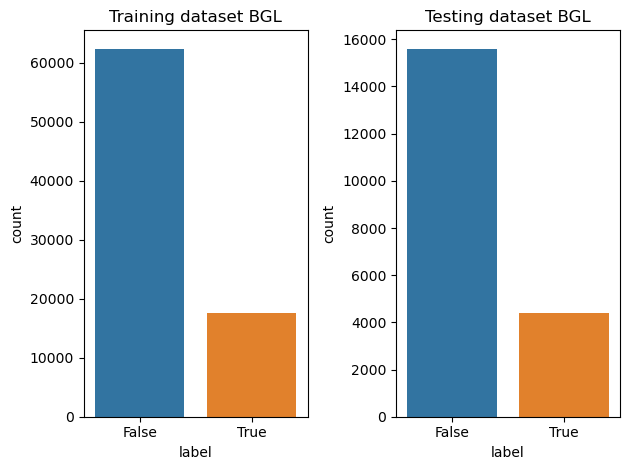

In [164]:
path_to_file="/kaggle/input/logs-params"
train="BGL_train_params.csv"
test="BGL_test_params.csv"
data='BGL'
col='label'

BGL_train,BGL_test=read_csv(path_to_file,train,test,data,col)

Train Shape: (79999, 20) Test Shape: (20001, 11)


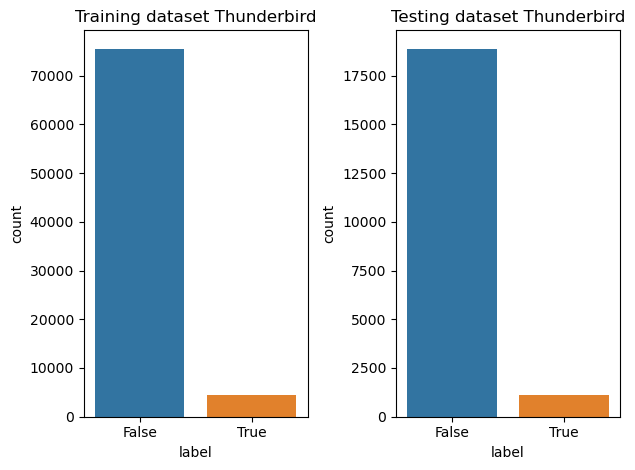

In [165]:
path_to_file="/kaggle/input/logs-params"
train="Thunderbird_train_params.csv"
test="Thunderbird_test_params.csv"
col='label'
data='Thunderbird'

thunder_train,thunder_test=read_csv(path_to_file,train,test,data,col)

In [166]:
thunder_train.columns

Index(['Unnamed: 0', 'timestamp', 'text', 'label', 'filename', 'clusters',
       'p-0-0', 'p-0-1', 'p-0-2', 'p-0-3', 'p-0-4', 'p-0-5', 'p-0-6', 'p-4-0',
       'p-8-0', 'p-9-0', 'p-11-0', 'p-18-0', 'p-37-0', 'p-37-1'],
      dtype='object')

In [169]:
thunder_test.columns

Index(['Unnamed: 0', 'timestamp', 'text', 'label', 'filename', 'clusters',
       'p-0-0', 'p-0-1', 'p-0-2', 'p-8-0', 'p-18-0'],
      dtype='object')

In [171]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def encoding(train,test,cluster=None,label=None):

    le = LabelEncoder()
    ohe = OneHotEncoder()

    train_dummies = pd.get_dummies(train['clusters'])
    train['label'] = le.fit_transform(train['label'])

    test_dummies = pd.get_dummies(test['clusters'])
    test['label'] = le.fit_transform(test['label'])

    for col in train_dummies.columns:
        if not col in test_dummies.columns:
            continue
        col_name = 'c' + str(col)
        train[col_name] = train_dummies[col]
        test[col_name] = test_dummies[col]

    train.drop(columns=['clusters'], inplace=True)
    test.drop(columns=['clusters'], inplace=True)
    train.head()
    return train,test

In [172]:
encoded_train_BGL,encoded_test_BGL= encoding(BGL_train,BGL_test,cluster='clusters',label='label')
encoded_train_t,encoded_test_t= encoding(thunder_train,thunder_test,cluster='clusters',label='label')

In [177]:
#encoded_train_t.columns
#encoded_test_t.columns

In [178]:
def train_test(train, test):
    for col in train.columns:
        if col not in test.columns:
            test[col] = 0
    
    for col in test.columns:
        if col not in train.columns:
            train[col] = 0

    X_train= train.drop(columns = ['Unnamed: 0', 'label','text','filename','timestamp'])
    X_train.fillna(0,inplace=True)
    y_train=train.loc[:,'label']
    
    X_test= test.drop(columns = ['Unnamed: 0', 'label','text','filename','timestamp'])
    X_test.fillna(0,inplace=True)
    y_test=test.loc[:,'label']
    
    return X_train,y_train.values,X_test,y_test.values

In [181]:
x_train_BGL,y_train_BGL,x_test_BGL,y_test_BGL = train_test(encoded_train_BGL,encoded_test_BGL)
x_train_t,y_train_t,x_test_t,y_test_t=train_test(encoded_train_t,encoded_test_t)

In [182]:
print("columns for the x_test file"+ str(x_test_t.columns))
print("columns for the x_train file"+ str(x_train_t.columns))

columns for the x_test fileIndex(['p-0-0', 'p-0-1', 'p-0-2', 'p-8-0', 'p-18-0', 'c0', 'c1', 'c2', 'c3',
       'c5', 'c6', 'c8', 'c9', 'c10', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18',
       'c20', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c29', 'c32', 'c33',
       'c34', 'c35', 'c36', 'c38', 'c39', 'p-0-3', 'p-0-4', 'p-0-5', 'p-0-6',
       'p-4-0', 'p-9-0', 'p-11-0', 'p-37-0', 'p-37-1'],
      dtype='object')
columns for the x_train fileIndex(['p-0-0', 'p-0-1', 'p-0-2', 'p-0-3', 'p-0-4', 'p-0-5', 'p-0-6', 'p-4-0',
       'p-8-0', 'p-9-0', 'p-11-0', 'p-18-0', 'p-37-0', 'p-37-1', 'c0', 'c1',
       'c2', 'c3', 'c5', 'c6', 'c8', 'c9', 'c10', 'c13', 'c14', 'c15', 'c16',
       'c17', 'c18', 'c20', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c29',
       'c32', 'c33', 'c34', 'c35', 'c36', 'c38', 'c39'],
      dtype='object')


In [183]:
x_train_BGL = x_train_BGL[x_test_BGL.columns]
x_train_t=x_train_t[x_test_t.columns]

In [185]:
x_train_t.columns==x_test_t.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [186]:
print(x_train_BGL.shape,y_train_BGL.shape,x_test_BGL.shape,y_test_BGL.shape)
print(x_train_t.shape,y_train_t.shape,x_test_t.shape,y_test_t.shape)

(79992, 28) (79992,) (19999, 28) (19999,)
(79999, 44) (79999,) (20001, 44) (20001,)


## Logistic Regression

### BGL

In [105]:
from sklearn import tree
from sklearn.ensemble import IsolationForest
from sklearn.svm import LinearSVC

lr_BGL = LogisticRegression(class_weight='balanced')
lr_BGL.fit(x_train_BGL, y_train_BGL)

LogisticRegression(class_weight='balanced')

Train Result:
Accuracy Score: 97.41%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      1.000000      0.894761  0.974135      0.947380      0.976857
recall         0.966843      1.000000  0.974135      0.983422      0.974135
f1-score       0.983142      0.944458  0.974135      0.963800      0.974635
support    62401.000000  17591.000000  0.974135  79992.000000  79992.000000
_______________________________________________
Confusion Matrix: 
 [[60332  2069]
 [    0 17591]]

_______________________________________________
Recall Score: 
 1.0
_______________________________________________
Roc AUC Score: 
 0.9834217400362173


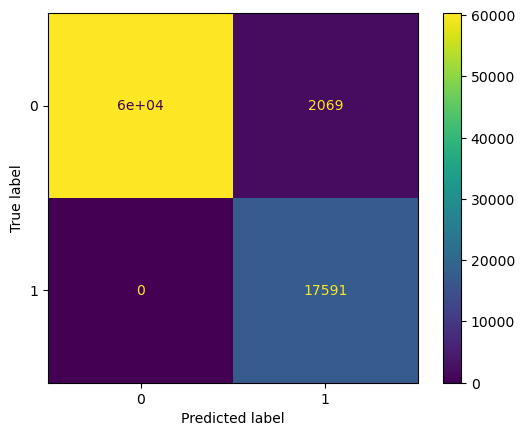

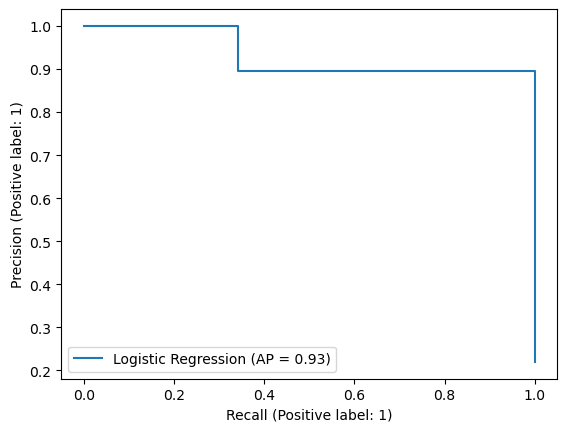

In [108]:
pred_BGL = lr_BGL.predict(x_train_BGL)
lr_report = pd.DataFrame(classification_report(y_train_BGL, pred_BGL, output_dict=True))
print("Train Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_train_BGL, pred_BGL) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{lr_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_train_BGL, pred_BGL)}\n")
print("_______________________________________________")
print(f'Recall Score: \n {recall_score(y_train_BGL, pred_BGL)}')
print("_______________________________________________")
print(f'Roc AUC Score: \n {roc_auc_score(y_train_BGL, pred_BGL)}')

lr_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_train_BGL, pred_BGL)
plt.show()

#pred_probs = lr.predict_prob(x_test)
#precision, recall, thresholds = precision_recall_curve(y_test, pred_probs)

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    lr_BGL, x_train_BGL, y_train_BGL, name="Logistic Regression"
)

Train Result:
Accuracy Score: 97.41%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      1.000000      0.894761  0.974135      0.947380      0.976857
recall         0.966843      1.000000  0.974135      0.983422      0.974135
f1-score       0.983142      0.944458  0.974135      0.963800      0.974635
support    62401.000000  17591.000000  0.974135  79992.000000  79992.000000
_______________________________________________
Confusion Matrix: 
 [[60332  2069]
 [    0 17591]]

_______________________________________________
Recall Score: 
 1.0
_______________________________________________
Roc AUC Score: 
 0.9834217400362173


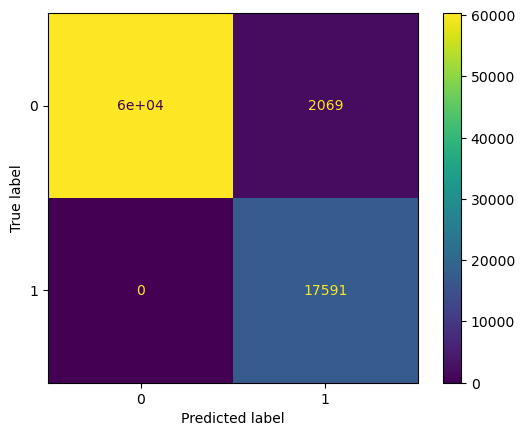

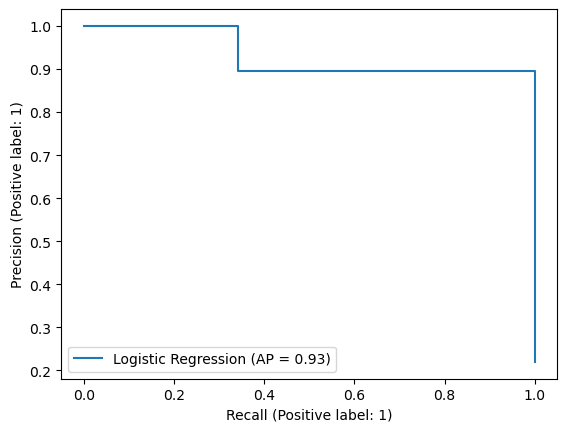

In [109]:
pred = lr.predict(x_train_BGL)
lr_report = pd.DataFrame(classification_report(y_train_BGL, pred, output_dict=True))
print("Train Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_train_BGL, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{lr_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_train_BGL, pred)}\n")
print("_______________________________________________")
print(f'Recall Score: \n {recall_score(y_train_BGL, pred)}')
print("_______________________________________________")
print(f'Roc AUC Score: \n {roc_auc_score(y_train_BGL, pred)}')

lr_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_train_BGL, pred)
plt.show()

#pred_probs = lr.predict_prob(x_test)
#precision, recall, thresholds = precision_recall_curve(y_test, pred_probs)

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    lr, x_train_BGL, y_train_BGL, name="Logistic Regression"
)

Test Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                 0       1  accuracy  macro avg  weighted avg
precision      1.0     1.0       1.0        1.0           1.0
recall         1.0     1.0       1.0        1.0           1.0
f1-score       1.0     1.0       1.0        1.0           1.0
support    15601.0  4398.0       1.0    19999.0       19999.0
_______________________________________________
Confusion Matrix: 
 [[15601     0]
 [    0  4398]]

_______________________________________________
Recall Score: 
 1.0
_______________________________________________
Roc AUC Score: 
 1.0


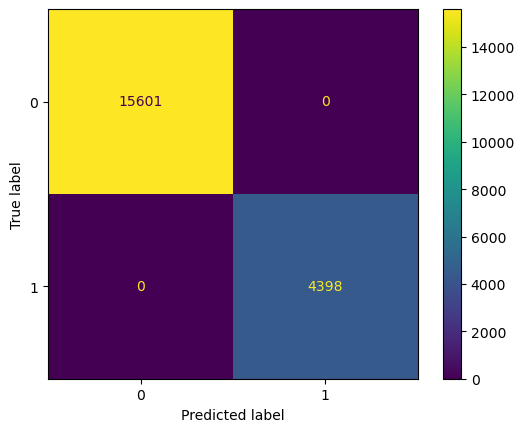

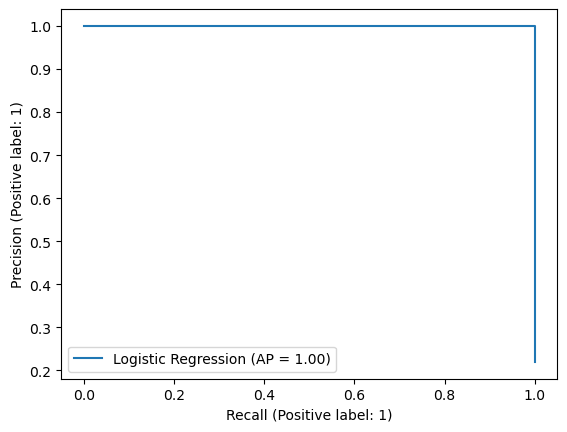

In [110]:
pred = lr.predict(x_test_BGL)
lr_report = pd.DataFrame(classification_report(y_test_BGL, pred, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test_BGL, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{lr_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test_BGL, pred)}\n")
print("_______________________________________________")
print(f'Recall Score: \n {recall_score(y_test_BGL, pred)}')
print("_______________________________________________")
print(f'Roc AUC Score: \n {roc_auc_score(y_test_BGL, pred)}')

lr_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test_BGL, pred)
plt.show()

#pred_probs = lr.predict_prob(x_test)
#precision, recall, thresholds = precision_recall_curve(y_test, pred_probs)

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    lr, x_test_BGL, y_test_BGL, name="Logistic Regression"
)

### Thunderbird

In [194]:
from sklearn import tree
from sklearn.ensemble import IsolationForest
from sklearn.svm import LinearSVC

lr_t = LogisticRegression(class_weight='balanced')
lr_t.fit(x_train_t, y_train_t)

LogisticRegression(class_weight='balanced')

Test Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999947     1.000000   0.99995      0.999974       0.99995
recall         1.000000     0.999107   0.99995      0.999554       0.99995
f1-score       0.999974     0.999553   0.99995      0.999763       0.99995
support    18881.000000  1120.000000   0.99995  20001.000000   20001.00000
_______________________________________________
Confusion Matrix: 
 [[18881     0]
 [    1  1119]]

_______________________________________________
Recall Score: 
 0.9991071428571429
_______________________________________________
Roc AUC Score: 
 0.9995535714285715


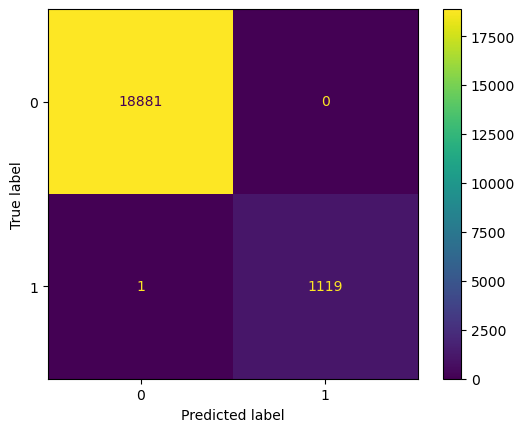

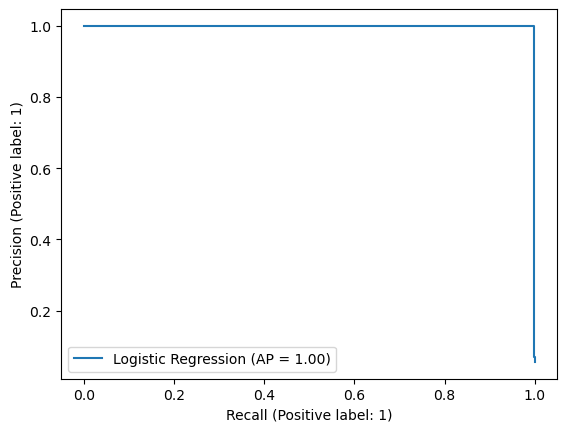

In [202]:
pred = lr_t.predict(x_test_t)
lr_report = pd.DataFrame(classification_report(y_test_t, pred, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test_t, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{lr_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test_t, pred)}\n")
print("_______________________________________________")
print(f'Recall Score: \n {recall_score(y_test_t, pred)}')
print("_______________________________________________")
print(f'Roc AUC Score: \n {roc_auc_score(y_test_t, pred)}')

lr_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test_t, pred)
plt.show()

#pred_probs = lr.predict_prob(x_test)
#precision, recall, thresholds = precision_recall_curve(y_test, pred_probs)

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    lr_t, x_test_t, y_test_t, name="Logistic Regression"
)

# XGBoost

### Thunderbird

In [222]:
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(x_train_t, y_train_t)
# make predictions
preds = bst.predict(x_test_t)


In [223]:
rmse = mean_squared_error(y_test_t, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 0.007


Test Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999947     1.000000   0.99995      0.999974       0.99995
recall         1.000000     0.999107   0.99995      0.999554       0.99995
f1-score       0.999974     0.999553   0.99995      0.999763       0.99995
support    18881.000000  1120.000000   0.99995  20001.000000   20001.00000
_______________________________________________
Confusion Matrix: 
 [[18881     0]
 [    1  1119]]

_______________________________________________
Recall Score: 
 0.9991071428571429
_______________________________________________
Roc AUC Score: 
 0.9995535714285715


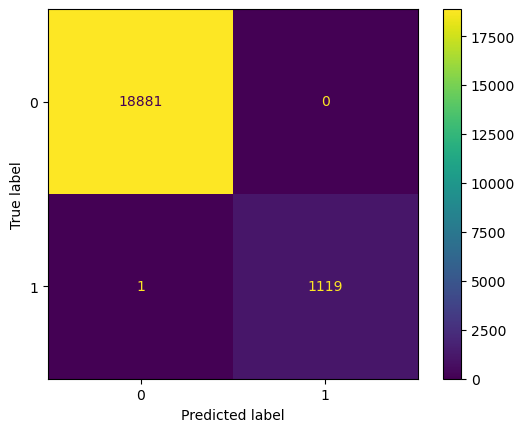

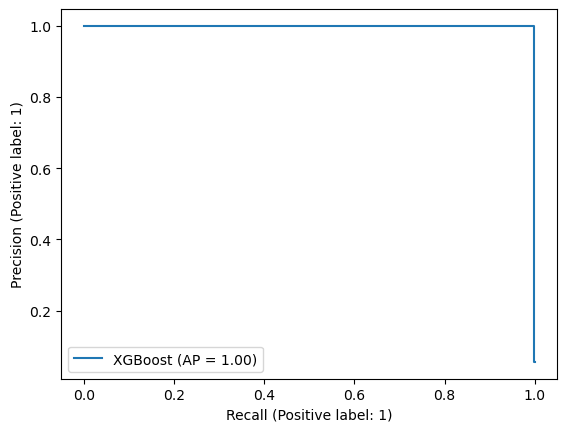

In [224]:
XGBOOST_report = pd.DataFrame(classification_report(y_test_t, preds, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test_t, preds) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{lr_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test_t, preds)}\n")
print("_______________________________________________")
print(f'Recall Score: \n {recall_score(y_test_t, preds)}')
print("_______________________________________________")
print(f'Roc AUC Score: \n {roc_auc_score(y_test_t, preds)}')

XGBOOST_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test_t, preds)
plt.show()

#pred_probs = lr.predict_prob(x_test)
#precision, recall, thresholds = precision_recall_curve(y_test, pred_probs)

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    bst, x_test_t, y_test_t, name="XGBoost"
)

### BGL

In [225]:
bst_BGL = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, 
                        objective='binary:logistic')
# fit model
bst.fit(x_train_BGL, y_train_BGL)
# make predictions
preds = bst.predict(x_test_BGL)


In [220]:
rmse = mean_squared_error(y_test_BGL, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 0.163


Test Result:
Accuracy Score: 97.35%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999947     1.000000   0.99995      0.999974       0.99995
recall         1.000000     0.999107   0.99995      0.999554       0.99995
f1-score       0.999974     0.999553   0.99995      0.999763       0.99995
support    18881.000000  1120.000000   0.99995  20001.000000   20001.00000
_______________________________________________
Confusion Matrix: 
 [[15072   529]
 [    0  4398]]

_______________________________________________
Recall Score: 
 1.0
_______________________________________________
Roc AUC Score: 
 0.9830459585923979


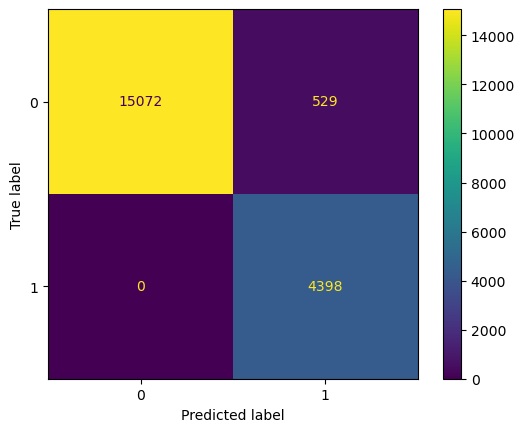

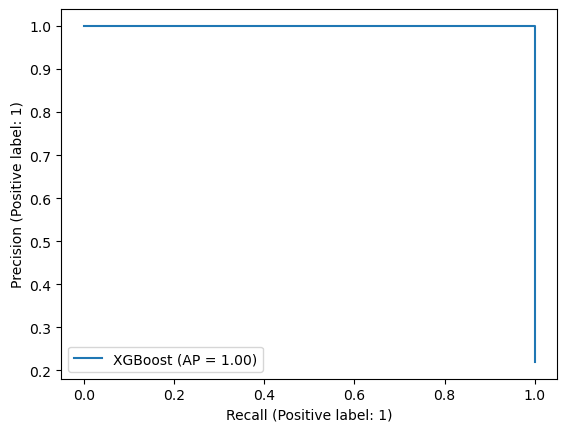

In [226]:
xgboost_report = pd.DataFrame(classification_report(y_test_BGL, preds, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test_BGL, preds) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{lr_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test_BGL, preds)}\n")
print("_______________________________________________")
print(f'Recall Score: \n {recall_score(y_test_BGL, preds)}')
print("_______________________________________________")
print(f'Roc AUC Score: \n {roc_auc_score(y_test_BGL, preds)}')

lr_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test_BGL, preds)
plt.show()

#pred_probs = lr.predict_prob(x_test)
#precision, recall, thresholds = precision_recall_curve(y_test, pred_probs)

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    bst, x_test_BGL, y_test_BGL, name="XGBoost"
)